# TACO (Garbage) Detection (SSD MobileNet v2) with TensorFlow

TACO can be found here: http://tacodataset.org/. 🌮 is an open image dataset of waste in the wild. It contains photos of litter taken under diverse environments, from tropical beaches to London streets.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.python.util import compat
from tensorflow.core.protobuf import saved_model_pb2
from google.protobuf import text_format
import pprint
import json
import os


import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import os
import json
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change to the desired directory
os.chdir('/content/drive/MyDrive/Capstone/')

# Verify the current working directory
print("Current working directory:", os.getcwd())

# List files in the current directory
!ls


# 1. PERSIAPAN DATASET TACO
DATA_DIR = "/content/drive/MyDrive/Capstone/data"
ANNOTATIONS_FILE = os.path.join(DATA_DIR, "annotations.json")
IMG_DIR = os.path.join(DATA_DIR, "images")

Current working directory: /content/drive/MyDrive/Capstone
data	  download.py				   models     requirements.txt
detector  garbage-detection-with-tensorflow.ipynb  README.md


We are going to use pretrained models in this notebook to show how you can do inference on them of unseen images. The pretrained models can be found here: https://www.kaggle.com/bouweceunen/trained-models-taco-trash-annotations-in-context

In [ ]:
# needed to install object_detection library and enlarge labels
! rm -rf ./models && git clone https://github.com/tensorflow/models.git \
    && sed -i "s#ImageFont.truetype('arial.ttf', 24)#ImageFont.truetype('arial.ttf', 50)#g" ./models/research/object_detection/utils/visualization_utils.py \
    && cp /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf /usr/share/fonts/truetype/dejavu/arial.ttf

Cloning into 'models'...
remote: Enumerating objects: 98711, done.
remote: Counting objects: 100% (1218/1218), done.
remote: Compressing objects: 100% (669/669), done.
remote: Total 98711 (delta 657), reused 1014 (delta 522), pack-reused 97493 (from 1)
Receiving objects: 100% (98711/98711), 622.26 MiB | 12.13 MiB/s, done.
Resolving deltas: 100% (71650/71650), done.
Updating files: 100% (3875/3875), done.
cp: cannot stat '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf': No such file or directory


In [ ]:
# install object_detection library
! cd models/research \
    && protoc object_detection/protos/*.proto --python_out=. \
    && cp object_detection/packages/tf2/setup.py . && \
    python3 -m pip install --use-feature=2020-resolver .


Usage:   
  /usr/bin/python3 -m pip install [options] <requirement specifier> [package-index-options] ...
  /usr/bin/python3 -m pip install [options] -r <requirements file> [package-index-options] ...
  /usr/bin/python3 -m pip install [options] [-e] <vcs project url> ...
  /usr/bin/python3 -m pip install [options] [-e] <local project path> ...
  /usr/bin/python3 -m pip install [options] <archive url/path> ...

option --use-feature: invalid choice: '2020-resolver' (choose from 'fast-deps', 'truststore', 'no-binary-enable-wheel-cache')


In [ ]:
!pip install protobuf==3.20.3


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Capstone/models/research')
sys.path.append('/content/drive/MyDrive/Capstone/models/research/slim')


In [ ]:
!cd /content/drive/MyDrive/Capstone/models/research && protoc object_detection/protos/*.proto --python_out=.


In [ ]:
!cd /content/drive/MyDrive/Capstone/models/research && cp object_detection/packages/tf2/setup.py . && python3 -m pip install .


Processing /content/drive/MyDrive/Capstone/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!ls /content/drive/MyDrive/Capstone/models/research/object_detection/protos | grep .py


anchor_generator_pb2.py
argmax_matcher_pb2.py
bipartite_matcher_pb2.py
box_coder_pb2.py
box_predictor_pb2.py
calibration_pb2.py
center_net_pb2.py
eval_pb2.py
faster_rcnn_box_coder_pb2.py
faster_rcnn_pb2.py
flexible_grid_anchor_generator_pb2.py
fpn_pb2.py
graph_rewriter_pb2.py
grid_anchor_generator_pb2.py
hyperparams_pb2.py
image_resizer_pb2.py
__init__.py
input_reader_pb2.py
keypoint_box_coder_pb2.py
losses_pb2.py
matcher_pb2.py
mean_stddev_box_coder_pb2.py
model_pb2.py
multiscale_anchor_generator_pb2.py
optimizer_pb2.py
pipeline_pb2.py
post_processing_pb2.py
preprocessor_pb2.py
region_similarity_calculator_pb2.py
square_box_coder_pb2.py
ssd_anchor_generator_pb2.py
ssd_pb2.py
string_int_label_map_pb2.py
target_assigner_pb2.py
train_pb2.py


In [ ]:
!pip uninstall tensorflow-object-detection-api
!pip install tensorflow-object-detection-api


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.4/577.4 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.2/769.2 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.7 MB/s eta 0:00:00
  Created wheel for tensorflow-object-detection-api: filename=tensorflow_object_detection_api-0.1.1-py3-none-any.whl size=844489 sha256=082d5c3e458eacd29348e3a26321b

In [ ]:
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util, label_map_util
from object_detection.protos import string_int_label_map_pb2

2024-11-25 07:27:03.862404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732519623.888560    7892 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732519623.896189    7892 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 07:27:03.922082: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Create LabelMap

First we need to create the label map.

In [ ]:
DATA_DIR = '/content/drive/MyDrive/Capstone/data'
ANNOTATIONS_FILE = os.path.join(DATA_DIR, 'annotations.json')
NCLASSES = 60

In [ ]:
#cek struktur
# Memeriksa struktur JSON
with open(ANNOTATIONS_FILE) as f:
    annotations = json.load(f)

print(type(annotations))  # Apakah dictionary?
print(annotations.keys())  # Apa saja key yang tersedia?


<class 'dict'>
dict_keys(['info', 'images', 'annotations', 'scene_annotations', 'licenses', 'categories', 'scene_categories'])


In [ ]:
# Membaca dataset TACO (annotations)
with open(ANNOTATIONS_FILE) as f:
    datas = json.load(f)

# Mengakses kategori
images = datas['images']  # Data gambar
annotations = datas['annotations']  # Data anotasi
categories = datas['categories']  # Data kategori

In [ ]:
# Mengonversi data bounding box ke format yang digunakan Keras
image_paths, bboxes, labels = [], [], []
category_map = {cat['id']: cat['name'] for cat in categories}

In [ ]:
# Mengecek data yang berhasil di-load
print(f"Jumlah kategori: {len(categories)}")
print(f"Jumlah gambar: {len(images)}")
print(f"Jumlah anotasi: {len(annotations)}")

Jumlah kategori: 60
Jumlah gambar: 1500
Jumlah anotasi: 4784


In [ ]:
print(type(datas))
annotations = datas['annotations']
for data in annotations[:10]:
    print(data)



<class 'dict'>
{'id': 1, 'image_id': 0, 'category_id': 6, 'segmentation': [[561.0, 1238.0, 568.0, 1201.0, 567.0, 1175.0, 549.0, 1127.0, 538.0, 1089.0, 519.0, 1043.0, 517.0, 1005.0, 523.0, 964.0, 529.0, 945.0, 520.0, 896.0, 525.0, 862.0, 536.0, 821.0, 554.0, 769.0, 577.0, 727.0, 595.0, 678.0, 596.0, 585.0, 588.0, 346.0, 581.0, 328.0, 569.0, 306.0, 570.0, 276.0, 576.0, 224.0, 560.0, 205.0, 564.0, 170.0, 578.0, 154.0, 608.0, 136.0, 649.0, 127.0, 688.0, 127.0, 726.0, 129.0, 759.0, 141.0, 784.0, 153.0, 792.0, 177.0, 788.0, 193.0, 782.0, 209.0, 792.0, 238.0, 802.0, 271.0, 802.0, 294.0, 791.0, 319.0, 789.0, 360.0, 794.0, 395.0, 810.0, 529.0, 819.0, 609.0, 841.0, 675.0, 882.0, 728.0, 916.0, 781.0, 928.0, 802.0, 938.0, 834.0, 940.0, 856.0, 939.0, 873.0, 938.0, 884.0, 944.0, 901.0, 951.0, 917.0, 956.0, 942.0, 960.0, 972.0, 964.0, 1013.0, 959.0, 1036.0, 952.0, 1081.0, 952.0, 1106.0, 934.0, 1163.0, 935.0, 1174.0, 949.0, 1209.0, 954.0, 1235.0, 952.0, 1273.0, 953.0, 1296.0, 946.0, 1320.0, 930.0, 134

In [ ]:
# Parsing data (gambar dan bounding box) dari format COCO
image_paths, bboxes, labels = [], [], []
category_map = {cat['id']: cat['name'] for cat in categories}  # Memetakan category_id ke nama kategori

# Mengakses 'annotations' yang ada di dalam dictionary 'datas'
annotations = datas['annotations']

for data in annotations:
    img_id = data["image_id"]  # ID gambar yang terkait dengan annotation

    # Mencari data gambar yang sesuai dengan image_id
    img_data = next((img for img in images if img["id"] == img_id), None)
    if img_data is None:
        continue  # Jika gambar tidak ditemukan, lewati annotation ini

    # Path gambar
    image_path = os.path.join(IMG_DIR, img_data["file_name"])

    # Bounding box format [x, y, width, height]
    bbox = data["bbox"]  # Akses bounding box dengan benar

    # Kategori objek berdasarkan category_id, jika ingin nama kategori gunakan category_map
    label = category_map.get(data["category_id"], "Unknown")  # Menyimpan nama kategori

    # Menyimpan data
    image_paths.append(image_path)
    bboxes.append(bbox)
    labels.append(label)

# Split dataset untuk training dan validasi
X_train, X_val, y_train, y_val = train_test_split(image_paths, list(zip(bboxes, labels)), test_size=0.2, random_state=42)


In [ ]:
# # Konversi data ke format numpy array atau tensor agar bisa digunakan oleh tf.data.Dataset
# bboxes = np.array(bboxes)
# labels = np.array(labels)

In [ ]:
# # Split dataset untuk training dan validasi
# X_train, X_val, y_train, y_val = train_test_split(image_paths, list(zip(bboxes, labels)), test_size=0.2, random_state=42)

In [ ]:
print(y_train)

[([1364.0, 1099.0, 91.0, 58.0], 'Other plastic'), ([858.0, 1707.0, 167.0, 125.0], 'Paper cup'), ([970.0, 1511.0, 44.0, 32.0], 'Unlabeled litter'), ([1419.0, 1399.0, 13.0, 37.0], 'Broken glass'), ([1050.0, 2530.0, 71.0, 55.0], 'Broken glass'), ([1403.0, 1199.0, 179.0, 98.0], 'Clear plastic bottle'), ([1913.0, 2526.0, 125.0, 95.0], 'Pop tab'), ([436.0, 1816.0, 167.0, 125.0], 'Other plastic wrapper'), ([1413.0, 1673.0, 492.0, 401.0], 'Metal lid'), ([1356.0, 2046.0, 352.0, 274.0], 'Drink can'), ([840.0, 1028.0, 159.0, 158.0], 'Plastic bottle cap'), ([1294.0, 486.0, 444.0, 305.0], 'Plastic film'), ([851.0, 751.0476, 191.0, 186.0], 'Unlabeled litter'), ([1445.0, 1048.0, 457.0, 1110.0], 'Glass bottle'), ([2025.0, 1581.6, 93.0, 55.0], 'Unlabeled litter'), ([1357.8096, 2268.0476, 55.0, 33.0], 'Cigarette'), ([662.0, 2820.0, 40.0, 41.0], 'Cigarette'), ([153.0, 751.0, 109.0, 111.0], 'Plastic film'), ([1.0, 3101.0, 579.0, 457.0], 'Unlabeled litter'), ([1279.0, 2486.0, 28.0, 59.0], 'Cigarette'), ([4

In [ ]:
def load_image_and_label(bbox, label):
    # Konversi bounding box ke tensor dan normalisasi
    bbox = tf.convert_to_tensor(bbox, dtype=tf.float32) / 1024.0  # Normalisasi opsional
    # Konversi label ke tensor
    label = tf.convert_to_tensor(label, dtype=tf.int32)
    return bbox, label

# def load_image_and_label(image_path, bbox_label, img_size=(224, 224)):
#     # Pastikan image_path adalah tensor string
#     image_path = tf.strings.as_string(image_path)

#     img = tf.io.read_file(image_path)  # Membaca file gambar
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, img_size)
#     img = img / 255.0

#     bbox, label = bbox_label
#     return img, {"bbox": bbox, "label": label}

In [ ]:
print(y_train)

[(array([632., 989.,  44.,  51.]), 'Plastic bottle cap'), (array([ 531.,  292., 1006.,  672.]), 'Other carton'), (array([ 517.,  127.,  447., 1322.]), 'Glass bottle'), (array([632., 987., 500., 374.]), 'Clear plastic bottle')]


In [ ]:
for i, item in enumerate(y_train):
    print(f"Item {i}: {item}")
    print(f"  bbox type: {type(item[0])}, shape: {np.array(item[0]).shape}")  # Bbox ada di indeks 0
    print(f"  label type: {type(item[1])}")  # Label ada di indeks 1


Item 0: ([1364.0, 1099.0, 91.0, 58.0], 'Other plastic')
  bbox type: <class 'list'>, shape: (4,)
  label type: <class 'str'>
Item 1: ([858.0, 1707.0, 167.0, 125.0], 'Paper cup')
  bbox type: <class 'list'>, shape: (4,)
  label type: <class 'str'>
Item 2: ([970.0, 1511.0, 44.0, 32.0], 'Unlabeled litter')
  bbox type: <class 'list'>, shape: (4,)
  label type: <class 'str'>
Item 3: ([1419.0, 1399.0, 13.0, 37.0], 'Broken glass')
  bbox type: <class 'list'>, shape: (4,)
  label type: <class 'str'>
Item 4: ([1050.0, 2530.0, 71.0, 55.0], 'Broken glass')
  bbox type: <class 'list'>, shape: (4,)
  label type: <class 'str'>
Item 5: ([1403.0, 1199.0, 179.0, 98.0], 'Clear plastic bottle')
  bbox type: <class 'list'>, shape: (4,)
  label type: <class 'str'>
Item 6: ([1913.0, 2526.0, 125.0, 95.0], 'Pop tab')
  bbox type: <class 'list'>, shape: (4,)
  label type: <class 'str'>
Item 7: ([436.0, 1816.0, 167.0, 125.0], 'Other plastic wrapper')
  bbox type: <class 'list'>, shape: (4,)
  label type: <clas

In [ ]:
# Ekstrak label kategori dari y_train
labels = [item[1] for item in y_train]

print("Labels:", labels)


Labels: ['Other plastic', 'Paper cup', 'Unlabeled litter', 'Broken glass', 'Broken glass', 'Clear plastic bottle', 'Pop tab', 'Other plastic wrapper', 'Metal lid', 'Drink can', 'Plastic bottle cap', 'Plastic film', 'Unlabeled litter', 'Glass bottle', 'Unlabeled litter', 'Cigarette', 'Cigarette', 'Plastic film', 'Unlabeled litter', 'Cigarette', 'Drink carton', 'Pop tab', 'Foam cup', 'Unlabeled litter', 'Plastic bottle cap', 'Drink can', 'Unlabeled litter', 'Cigarette', 'Glass bottle', 'Normal paper', 'Garbage bag', 'Tissues', 'Plastic film', 'Garbage bag', 'Cigarette', 'Cigarette', 'Other carton', 'Plastic lid', 'Clear plastic bottle', 'Scrap metal', 'Meal carton', 'Other plastic wrapper', 'Plastic straw', 'Plastic film', 'Drink can', 'Plastic bottle cap', 'Cigarette', 'Drink can', 'Plastic film', 'Other plastic bottle', 'Other plastic', 'Cigarette', 'Drink can', 'Aluminium foil', 'Unlabeled litter', 'Single-use carrier bag', 'Plastic bottle cap', 'Plastic film', 'Metal bottle cap', 'Ot

In [ ]:
# Step 1: Buat mapping label ke nilai numerik
labels = [item[1] for item in y_train + y_val]
label_mapping = {label: idx for idx, label in enumerate(sorted(set(labels)))}
print("Label Mapping:", label_mapping)

Label Mapping: {'Aerosol': 0, 'Aluminium blister pack': 1, 'Aluminium foil': 2, 'Battery': 3, 'Broken glass': 4, 'Carded blister pack': 5, 'Cigarette': 6, 'Clear plastic bottle': 7, 'Corrugated carton': 8, 'Crisp packet': 9, 'Disposable food container': 10, 'Disposable plastic cup': 11, 'Drink can': 12, 'Drink carton': 13, 'Egg carton': 14, 'Foam cup': 15, 'Foam food container': 16, 'Food Can': 17, 'Food waste': 18, 'Garbage bag': 19, 'Glass bottle': 20, 'Glass cup': 21, 'Glass jar': 22, 'Magazine paper': 23, 'Meal carton': 24, 'Metal bottle cap': 25, 'Metal lid': 26, 'Normal paper': 27, 'Other carton': 28, 'Other plastic': 29, 'Other plastic bottle': 30, 'Other plastic container': 31, 'Other plastic cup': 32, 'Other plastic wrapper': 33, 'Paper bag': 34, 'Paper cup': 35, 'Paper straw': 36, 'Pizza box': 37, 'Plastic bottle cap': 38, 'Plastic film': 39, 'Plastic glooves': 40, 'Plastic lid': 41, 'Plastic straw': 42, 'Plastic utensils': 43, 'Polypropylene bag': 44, 'Pop tab': 45, 'Rope & 

In [ ]:
# Step 2: Konversi label string menjadi nilai numerik
y_train_mapped = [(item[0], label_mapping[item[1]]) for item in y_train]
y_val_mapped = [(item[0], label_mapping[item[1]]) for item in y_val]

In [ ]:
# Step 3: Ekstraksi bounding box (X) dan label (y)
X_train = [item[0] for item in y_train_mapped]
y_train = [item[1] for item in y_train_mapped]

X_val = [item[0] for item in y_val_mapped]
y_val = [item[1] for item in y_val_mapped]


In [ ]:
# Step 5: Konversi menjadi tf.data.Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Step 6: Map, batch, dan prefetch dataset
train_data = train_data.map(load_image_and_label).batch(32).prefetch(tf.data.AUTOTUNE)
val_data = val_data.map(load_image_and_label).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
for sample in train_data.take(1):
    print("Sample Train Data:", sample)


Sample Train Data: (<tf.Tensor: shape=(32, 4), dtype=float32, numpy=
array([[1.33203125e+00, 1.07324219e+00, 8.88671875e-02, 5.66406250e-02],
       [8.37890625e-01, 1.66699219e+00, 1.63085938e-01, 1.22070312e-01],
       [9.47265625e-01, 1.47558594e+00, 4.29687500e-02, 3.12500000e-02],
       [1.38574219e+00, 1.36621094e+00, 1.26953125e-02, 3.61328125e-02],
       [1.02539062e+00, 2.47070312e+00, 6.93359375e-02, 5.37109375e-02],
       [1.37011719e+00, 1.17089844e+00, 1.74804688e-01, 9.57031250e-02],
       [1.86816406e+00, 2.46679688e+00, 1.22070312e-01, 9.27734375e-02],
       [4.25781250e-01, 1.77343750e+00, 1.63085938e-01, 1.22070312e-01],
       [1.37988281e+00, 1.63378906e+00, 4.80468750e-01, 3.91601562e-01],
       [1.32421875e+00, 1.99804688e+00, 3.43750000e-01, 2.67578125e-01],
       [8.20312500e-01, 1.00390625e+00, 1.55273438e-01, 1.54296875e-01],
       [1.26367188e+00, 4.74609375e-01, 4.33593750e-01, 2.97851562e-01],
       [8.31054688e-01, 7.33444929e-01, 1.86523438e-01,

2024-11-25 07:35:57.175346: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
# 2. MEMBANGUN MODEL DENGAN KERAS (TRANSFER LEARNING)
# Backbone menggunakan MobileNetV2
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freezing the backbone

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Custom head untuk object detection
def create_detection_head(base_model):
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    # Output bounding box (4 koordinat) + label (jumlah kategori)
    bbox_output = layers.Dense(4, activation="sigmoid", name="bbox")(x)
    label_output = layers.Dense(len(category_map), activation="softmax", name="label")(x)

    return models.Model(inputs=base_model.input, outputs=[bbox_output, label_output])

model = create_detection_head(base_model)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,602,368 (9.93 MB)

 Trainable params: 344,384 (1.31 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# 3. KOMPILASI DAN TRAINING
# Loss fungsi untuk bounding box dan label
losses = {
    "bbox": "mse",  # Mean Squared Error untuk bounding box
    "label": "sparse_categorical_crossentropy",  # Crossentropy untuk label
}
loss_weights = {"bbox": 1.0, "label": 1.0}

model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=losses, loss_weights=loss_weights, metrics=["accuracy"])


In [ ]:
# Training model
history = model.fit(train_data, validation_data=val_data, epochs=20)

Epoch 1/20


ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 4)

# Reconstruct Frozen Graph

Now we are going to reconstruct the TensorFlow frozen graph (.pb).

In [ ]:
detection_graph = reconstruct("/content/drive/MyDrive/semester_5/Gerbage_Detection/input/ssd_mobilenet_v2_taco_2018_03_29.pb")

Reconstructing Tensorflow model
Success!


# Validate Test Images

We can now test it on some test images.

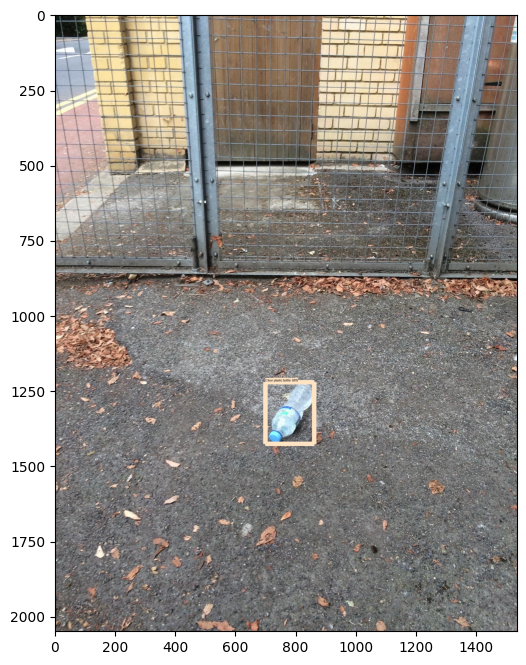

In [ ]:
detect(detection_graph, '/content/drive/MyDrive/semester_5/Gerbage_Detection/data/batch_1/000000.jpg')

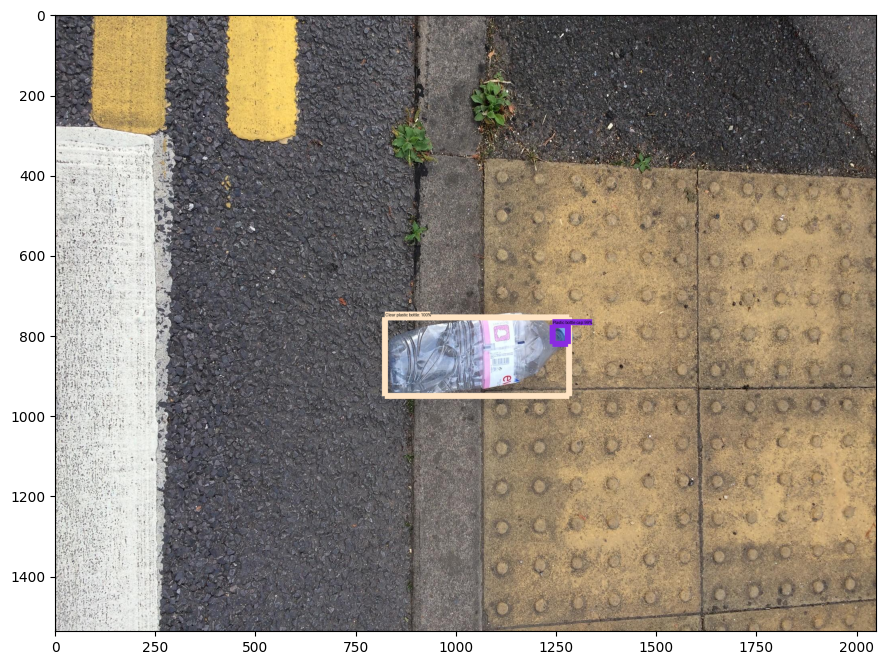

In [ ]:
detect(detection_graph, '/content/drive/MyDrive/semester_5/Gerbage_Detection/data/batch_1/000001.jpg')

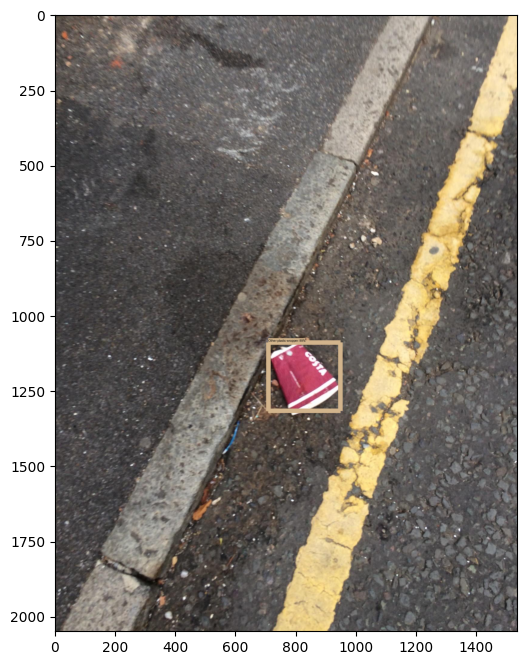

In [ ]:
detect(detection_graph, '/content/drive/MyDrive/semester_5/Gerbage_Detection/data/batch_1/000003.jpg')

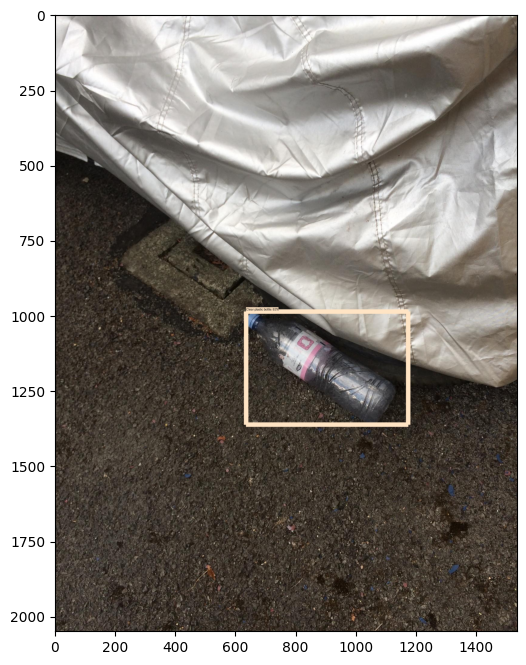

In [ ]:
detect(detection_graph, '/content/drive/MyDrive/semester_5/Gerbage_Detection/data/batch_1/000010.jpg')

# Cleanup

In [ ]:
! rm -rf ./models